In [ ]:
## This is a scratchpad used to experiment with code and generate figures, etc.

In [4]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from random import random
%matplotlib inline


In [36]:


images = []
measurements = []

# Select which datasets to use for training
# Thought about making this automatic, but wanted ability to select individual datasets
datasets = ['Train1', 'Train4', 'Train6']#, 'Train2', 'Train4', 'Train5']


# Loop thorugh selected datasets
for dataset in datasets:
    lines = []
    with open('data/' + dataset + '_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    # Center, Left, Right
    steer_correct = [0, 0.0, -0.0]
    for line in lines:
        for i in range(3): #center, left, right
            sourcepath = line[i]
            
            # Have to account for data captured on both my Mac and Windows machines 
            # (i.e.: path on windows has backslashes)
            if("/" in sourcepath):
                filename = sourcepath.split('/')[-1]
            else:
                filename = sourcepath.split('\\')[-1]
                                            
            currentpath = 'data/' + dataset + '/' + filename
            image = cv2.imread(currentpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV) # Suggested by nvidia
            images.append(image)
            images.append(cv2.flip(image,1)) #Flip image
            measurement = float(line[3]) + steer_correct[i]
            measurements.append(measurement)
            measurements.append(-measurement)
            
X_train_raw = np.array(images)
y_train_raw = np.array(measurements)


In [11]:
datasets = ['Train1', 'Train4', 'Train6', 'Train7', 'Train8', 'Train9', 'Train11', 'Train12']

# Camera image: [Center, Left, Right]
steer_correct = [0, 0.25, -0.25]
steer_angle_thresh = 0.04
steer_keep_pct = 0.33 # pct of angles withn +/- steer_angle_thresh to keep

samples = []
for dataset in datasets:
    tot_counter = 0; # Total number of entries
    dataset_counter = 0; # Number of entries per trainig set

    with open('data/' + dataset + '_log.csv') as csvfile:
        reader = csv.reader(csvfile)

        for line in reader:
            tot_counter = tot_counter + 1

            # Filter out steering angles
            this_steer = float(line[3])
            if ((abs(this_steer) >= steer_angle_thresh) |
                ((abs(this_steer) < steer_angle_thresh) & (random() < steer_keep_pct))):

                # Center, left, and right images were in each Line; same steer angle
                for i in range(3): # center, left, right

                    sourcepath = line[i]

                    # Here, had too account for data collected on both my Mac
                    # and PC, where the direction of slashes is different.
                    if("/" in sourcepath):
                        filename = sourcepath.split('/')[-1]
                    else:
                        filename = sourcepath.split('\\')[-1]

                    # All data was stored in 'data' folder in project directory
                    # Not included in git repository due to size
                    newpath = 'data/' + dataset + '/' + filename
                    newline = [newpath, this_steer+steer_correct[i]]
                    samples.append(newline)
                    dataset_counter = dataset_counter + 1

    # Print some stats about dataset.
    print("Total number of images in", dataset, ": " , tot_counter*3)
    print("Number of images in", dataset, "after fitering : ", dataset_counter)

# Print some stats about full set of images.
print("Final number of images (before flipping): ", len(samples))

Total number of images in Train1 :  4515
Number of images in Train1 after fitering :  2604
Total number of images in Train4 :  3747
Number of images in Train4 after fitering :  3327
Total number of images in Train6 :  4218
Number of images in Train6 after fitering :  3576
Total number of images in Train7 :  4110
Number of images in Train7 after fitering :  3930
Total number of images in Train8 :  12300
Number of images in Train8 after fitering :  11211
Total number of images in Train9 :  14712
Number of images in Train9 after fitering :  13356
Total number of images in Train11 :  4869
Number of images in Train11 after fitering :  3759
Total number of images in Train12 :  3234
Number of images in Train12 after fitering :  2688
Final number of images (before flipping):  44451


In [12]:
X_train = None
y_train = None

images = []
angles = []
for sample in samples:

    path = sample[0]
    angle = sample[1]

    image = cv2.imread(path)

    # Images are converted to YUV, as suggested in NVIDIA paper.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # Image and steering angle are flipped.
    images.append(image)
    images.append(cv2.flip(image,1)) #Flip image

    angles.append(float(angle))
    angles.append(float(-angle))
    
X_train = np.array(images)
y_train = np.array(angles)

# Save some memory.
images = None

Number of images:  88902


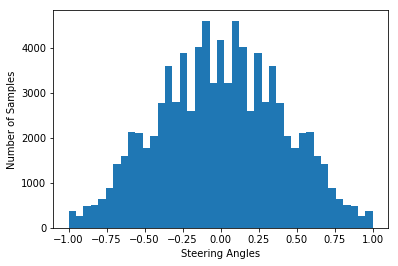

In [13]:
# Plot histogram

print("Number of images: ", len(y_train))

plt.figure()
plt.hist(y_train, bins=41, range=(-1.0, 1.0))
plt.xlabel("Steering Angles")
plt.ylabel("Number of Samples")
plt.show()


In [52]:
## Plotting function
def plot_imgs(X, y=np.array([]), cols = 3, cmap='brg'):
    
    num_cols = cols
    num_plots = len(X)
    num_rows = int(math.ceil(num_plots/2))
    
    shp = X[0].shape
    
    plotNum = 1
    plt.figure(figsize = (20, num_rows*4))
    for i in range(num_plots):
        
        thisFig = cv2.cvtColor(X[i], cv2.COLOR_YUV2RGB)
        #thisFig = X[i]
        plt.subplot(num_rows, num_cols, plotNum)
        plt.imshow(thisFig, cmap=cmap)
        if(len(y) > 0):
            #Generate a line to plot
            steer_angle = y[i]*25*math.pi/180 #steer value of 1 maps to 25% steering angle
            offst = np.int(math.atan(steer_angle)*shp[0]/2)
            #print(offst)
            xpnts = (math.ceil(shp[1]/2)+offst, shp[1]/2)
            ypnts = (math.ceil(shp[0]/2), shp[0]-2)
            plt.plot(xpnts, ypnts, '-', linewidth=4.0)
        plotNum = plotNum + 1




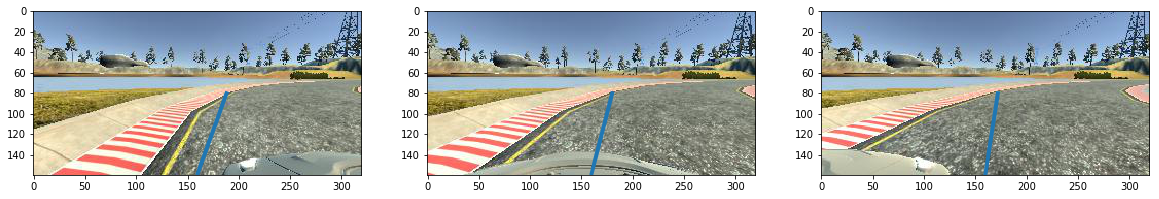

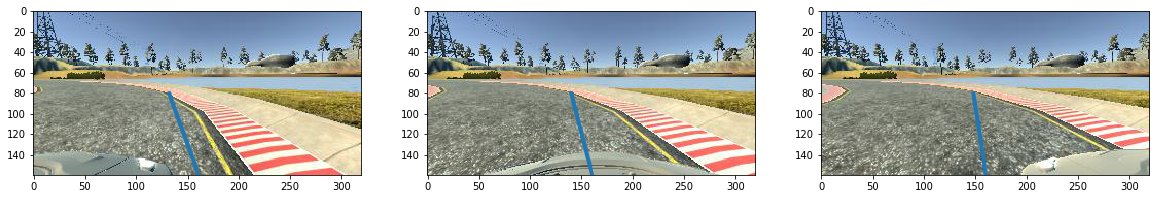

In [58]:
# Plot images with steering correction.

thisImg = 100
thisImg = 4250 #recovery

thisImg = thisImg*6 #For every center image, there are 6 images - center, center flip, left, left flip, right, right flip
test_imgs = [thisImg+2, thisImg, thisImg+4]
plot_imgs(X_train[test_imgs], y_train[test_imgs], cols=3)

# Plot flipped images with steering correction.
test_imgs = [thisImg+3, thisImg+1, thisImg+5]
plot_imgs(X_train[test_imgs], y_train[test_imgs], cols=3)  

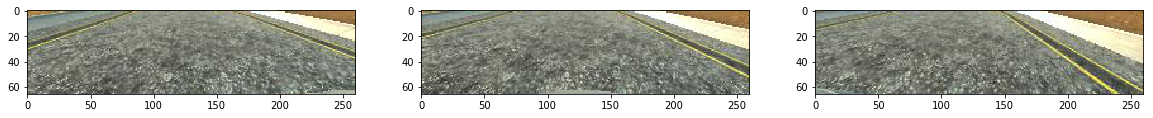

In [54]:
thisImg = 100


thisImg = thisImg*6 #For every center image, there are 6 images - center, center flip, left, left flip, right, right flip
test_imgs = [thisImg+2, thisImg, thisImg+4]

imgs =[]
for idx in test_imgs:
    img = X_train[idx]
    img = img[74:-20, 30:-30]
    imgs.append(img)

plot_imgs(imgs, cols=3)